In [1]:
import torch
from likelihoods import (BetaLikelihood_MeanParametrization, 
                         MultitaskBetaLikelihood,
                         HadamardBetaLikelihood)
import gpytorch
from data import PVWeatherLoader

In [94]:
# data parameters
DAY_INIT = 100
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 10
MINUTE_INTERVAL = 60
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 5
# create a tuple of 4 coordinates that form a polygon in the uk
# and a circle with a radius of r
CIRCLE_COORDS = (55, -1.5)
RADIUS = 0.3
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [95]:
loader = PVWeatherLoader(
    # number of days to get data for
    n_days=N_DAYS,
    # initial day of the data for that season
    # look at the data frame to see which day it is
    day_init=DAY_INIT,
    # number of systems to extract
    n_systems=N_SYSTEMS,
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    # the minute interval our data is sampled at 
    # (e.g. 60 for hourly, 30 for half hourly, 15 for 15 minutes, etc.)
    minute_interval=MINUTE_INTERVAL,
    # the minimum and maximum hour of the day to use
    # (e.g. 8 and 15 for 8am to 3pm)
    day_min=DAY_MIN,
    day_max=DAY_MAX,
    folder_name='pv_data',
    file_name='pv_and_weather.csv',
    distance_method='circle',
    # optionally use a season
    # season='spring',
    # optionally drop series with nan values
    drop_nan=False
)

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [96]:
from data.utils import train_test_split
from matplotlib import pyplot as plt
dict_input = {
    'x_train': [],
    'y_train': [],
    'x_test': [],
    'y_test': [],
    'task_indices_train': [],
    'task_indices_test': []
}

for i, (X, y) in enumerate(loader):
    
    x_train, y_train, x_test, y_test = train_test_split(X, y, hour=12, minute_interval=60, day_min=DAY_MIN, day_max=DAY_MAX, n_hours=12)
    n_tr = x_train.size(0)
    n_te = x_test.size(0)
    index_tr = torch.ones(n_tr, dtype=torch.long) * i
    index_te = torch.ones(n_te, dtype=torch.long) * i
    
    dict_input['x_train'].append(x_train)
    dict_input['y_train'].append(y_train)
    dict_input['x_test'].append(x_test)
    dict_input['y_test'].append(y_test)
    dict_input['task_indices_train'].append(index_tr)
    dict_input['task_indices_test'].append(index_te)

    if i == N_SYSTEMS -1:
        break
      
task_indices_train = torch.cat(dict_input['task_indices_train'])
task_indices_test = torch.cat(dict_input['task_indices_test'])
x_train = torch.cat(dict_input['x_train'])
x_test = torch.cat(dict_input['x_test'])
y_train = torch.cat(dict_input['y_train'], dim=0)
y_test = torch.cat(dict_input['y_test'], dim=0)

y_train = torch.cat(dict_input['y_train'])
y_test = torch.cat(dict_input['y_test'])

# for visualizing
_y_tr = torch.stack(dict_input['y_train'], dim=-1)
_y_te = torch.stack(dict_input['y_test'], dim=-1)


In [104]:
from gpytorch.variational import IndependentMultitaskVariationalStrategy

class IndependentMultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, 
                X : torch.Tensor,
                y : torch.Tensor,
                mean_module : gpytorch.means.Mean,
                covar_module : gpytorch.kernels.Kernel,
                likelihood : gpytorch.likelihoods.Likelihood,
                num_tasks : int):

        # need to ensure that y_train is in (0, 1)
        if y.max() >= 1:
            y[y >= 1] = 1 - 1e-4
        if y.min() <= 0:
            y[y <= 0] = 1e-4

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            X.size(0), batch_shape=torch.Size([num_tasks])
        )

        variational_strategy = IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, X, variational_distribution, learn_inducing_locations=False
            ),
            num_tasks=num_tasks,
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.X = X
        self.y = y
        self.mean_module = mean_module
        self.covar_module = covar_module
        self.likelihood = likelihood
        

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
    
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def fit(self,
            n_iter : int,
            lr : float,
            task_indices : torch.Tensor,
            verbose : bool = False,
            use_wandb : bool = False):
        self.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elbo = gpytorch.mlls.VariationalELBO(likelihood=self.likelihood, 
                                             model=self, 
                                             num_data=y_train.size(0))

        print_freq = 10

        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.X, task_indices=task_indices)
            loss = -elbo(output, self.y, task_indices=task_indices)
            loss.backward()
            optimizer.step()

            if verbose and (i + 1) % print_freq == 0:
                print(f"Iter {i + 1}/{n_iter} - Loss: {loss.item()}")

            if use_wandb and i % print_freq == 0:
                pass 
                # TODO log to wandb

In [106]:
from kernels import get_mean_covar
from gpytorch.constraints import Interval
num_tasks =  len(task_indices_test.unique())
mean, covar = get_mean_covar(num_latent=num_tasks)
likelihood = HadamardBetaLikelihood(num_tasks=num_tasks, 
                                    scale=30)
model = IndependentMultitaskGPModel(
    X=x_train,
    y=y_train,
    mean_module=mean,
    covar_module=covar,
    likelihood=likelihood,
    num_tasks=num_tasks)
model.fit(n_iter=300, 
          lr=0.1, 
          task_indices=task_indices_train,
          verbose=True)

initial scale:  tensor([[30., 30., 30., 30., 30.]], grad_fn=<SoftplusBackward0>)
Iter 10/300 - Loss: 1.040342092514038
Iter 20/300 - Loss: 0.09381985664367676
Iter 30/300 - Loss: -0.12089663743972778
Iter 40/300 - Loss: -0.27459901571273804
Iter 50/300 - Loss: -0.3383987545967102
Iter 60/300 - Loss: -0.37208789587020874
Iter 70/300 - Loss: -0.3926342725753784
Iter 80/300 - Loss: -0.40754663944244385
Iter 90/300 - Loss: -0.41963624954223633
Iter 100/300 - Loss: -0.4300329089164734
Iter 110/300 - Loss: -0.4394611716270447
Iter 120/300 - Loss: -0.4480917453765869
Iter 130/300 - Loss: -0.4560324549674988
Iter 140/300 - Loss: -0.46337080001831055
Iter 150/300 - Loss: -0.4701697826385498
Iter 160/300 - Loss: -0.47648531198501587
Iter 170/300 - Loss: -0.4823709726333618
Iter 180/300 - Loss: -0.48786890506744385
Iter 190/300 - Loss: -0.493022620677948
Iter 200/300 - Loss: -0.4978809356689453
Iter 210/300 - Loss: -0.502495288848877
Iter 220/300 - Loss: -0.5069290995597839
Iter 230/300 - Loss: -

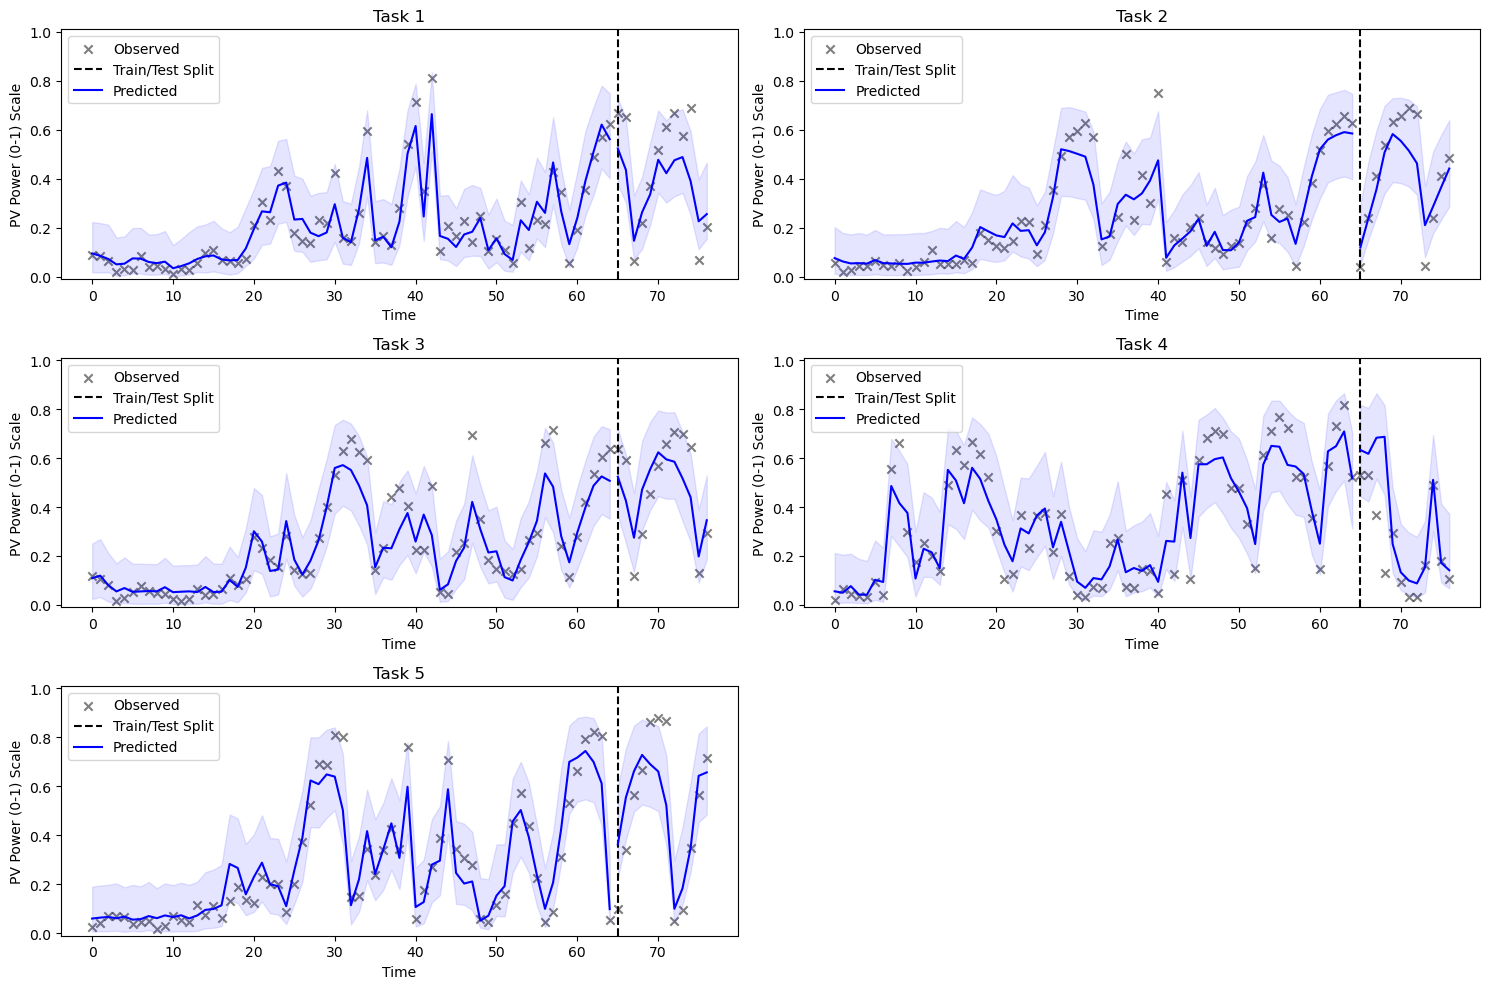

In [111]:
from matplotlib import pyplot as plt
import numpy as np

model.eval()
likelihood.eval()

with torch.no_grad():
    pred_dist_tr = model.likelihood(model(x_train, task_indices=task_indices_train), task_indices=task_indices_train)
    pred_dist_te = model.likelihood(model(x_test, task_indices=task_indices_test), task_indices=task_indices_test)
samples_tr = pred_dist_tr.sample(torch.Size([1000]))
samples_te = pred_dist_te.sample(torch.Size([1000]))

fig, axs = plt.subplots(num_tasks // 2 + 1, 2, figsize=(15, 5 * (num_tasks // 2)))
axs = axs.flatten()

for idx in torch.unique(task_indices_train):

    y_tr, y_te = _y_tr[:, idx], _y_te[:, idx]
    t = np.arange(0, len(y_tr) + len(y_te))
    t_tr, t_te = t[:len(y_tr)], t[len(y_tr):]

    axs[idx].scatter(t_tr, y_tr, label='Observed', color='black', marker='x', alpha=0.5)
    axs[idx].scatter(t_te, y_te,  color='k', marker='x', alpha=0.5)
    axs[idx].axvline(x=len(y_tr), color='k', linestyle='--', label='Train/Test Split')

    samples_tr_idx = samples_tr[:, :, task_indices_train == idx]
    samples_te_idx = samples_te[:, :, task_indices_test == idx]

    y_pred = samples_tr_idx.mean(dim=0).median(dim=0).values
    y_pred_te = samples_te_idx.mean(dim=0).median(dim=0).values
    
    lower_tr = np.quantile(samples_tr_idx.numpy(), 0.025, axis=0).mean(axis=0)
    upper_tr = np.quantile(samples_tr_idx.numpy(), 0.975, axis=0).mean(axis=0)

    lower_te = np.quantile(samples_te_idx.numpy(), 0.025, axis=0).mean(axis=0)
    upper_te = np.quantile(samples_te_idx.numpy(), 0.975, axis=0).mean(axis=0)
    
    
    axs[idx].plot(t_tr, y_pred, color='b', label='Predicted')
    axs[idx].fill_between(t_tr, lower_tr, upper_tr, alpha=0.1, color='blue')
    axs[idx].plot(t_te, y_pred_te, color='b')
    axs[idx].fill_between(t_te, lower_te, upper_te, alpha=0.1, color='blue')


    axs[idx].set_ylim(-0.01, 1.01)
    axs[idx].set_title(f'Task {idx + 1}')
    axs[idx].set_xlabel('Time')
    axs[idx].set_ylabel('PV Power (0-1) Scale')
    axs[idx].legend()

# remove unused axes
for ax in axs[num_tasks:]:
    ax.remove()

plt.tight_layout()
plt.show();

In [108]:
model.likelihood.scale

tensor([[28.3189, 27.1635, 26.8128, 22.1830, 23.4033]],
       grad_fn=<SoftplusBackward0>)